In [ ]:
# !rm -rf /content/dataset/images


# !rm -rf /content/dataset/labels

In this notebook, we'll go through the steps to train a CNN model for handwriting recognition. The model will be trained using the CTC(Connectionist Temporal Classification) loss.


![Webp.net-resizeimage.jpg](attachment:Webp.net-resizeimage.jpg)

Lets start by importing the necessary libraries. I'll be using Keras for building our CRNN model.

In [2]:
import os
import cv2
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam

## Load and view data

In [3]:
import os
import pandas as pd
import zipfile
from sklearn.model_selection import train_test_split

# Define paths to your zip files
image_zip_path = "/content/images_1.zip"
label_zip_path = "/content/Labels_1.zip"
output_dir = "/content/dataset"  # Directory to store extracted data

# Step 1: Extract images and labels
def extract_zip(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Extract images and labels
image_dir = os.path.join(output_dir, "images")
label_dir = os.path.join(output_dir, "labels")
os.makedirs(image_dir, exist_ok=True)
os.makedirs(label_dir, exist_ok=True)

extract_zip(image_zip_path, image_dir)
extract_zip(label_zip_path, label_dir)

# Step 2: Match images and labels
data = []
for img_name in sorted(os.listdir(image_dir)):  # Sort to align files if naming is consistent
    img_path = os.path.join(image_dir, img_name)
    label_name = os.path.splitext(img_name)[0] + ".txt"  # Assuming same base name for labels
    label_path = os.path.join(label_dir, label_name)

    if os.path.exists(label_path):
        with open(label_path, 'r', encoding="utf-8") as label_file:
            label_text = label_file.read().strip()
        data.append({"file_name": img_path, "text": label_text})
    else:
        print(f"Label not found for image: {img_name}")

# Step 3: Create a DataFrame and save to CSV
df = pd.DataFrame(data)
csv_path = os.path.join(output_dir, "dataset.csv")
df.to_csv(csv_path, index=False)
print(f"Dataset CSV saved to {csv_path}")

# Step 4: Split into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Save splits to separate CSV files
train_df.to_csv(os.path.join(output_dir, "train.csv"), index=False)
val_df.to_csv(os.path.join(output_dir, "val.csv"), index=False)

print("Data split into train and validation sets.")
print(f"Train set size: {len(train_df)}, Validation set size: {len(val_df)}")


Dataset CSV saved to /content/dataset/dataset.csv
Data split into train and validation sets.
Train set size: 7200, Validation set size: 1800


In [ ]:
# # FOR MACOS

# import os
# import pandas as pd
# import zipfile
# from sklearn.model_selection import train_test_split

# # Define paths to your zip files
# image_zip_path = "/content/images_1.zip"
# label_zip_path = "/content/Labels_1.zip"
# output_dir = "/content/dataset"  # Directory to store extracted data

# def extract_zip(zip_path, extract_to):
#     with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#         for file in zip_ref.namelist():
#             if "__MACOSX" in file or file.endswith('/'):  # Skip _MACOSX and directories
#                 continue

#             # Extract file to the correct location
#             file_name = os.path.basename(file)  # Get the actual file name
#             dest_path = os.path.join(extract_to, file_name)  # Destination path for the file
#             with zip_ref.open(file) as source, open(dest_path, 'wb') as target:
#                 target.write(source.read())

# # Extract images and labels
# image_dir = os.path.join(output_dir, "images")
# label_dir = os.path.join(output_dir, "labels")
# os.makedirs(image_dir, exist_ok=True)
# os.makedirs(label_dir, exist_ok=True)

# extract_zip(image_zip_path, image_dir)
# extract_zip(label_zip_path, label_dir)

# # Step 2: Match images and labels
# # Step 2: Match images and labels
# data = []
# for img_name in sorted(os.listdir(image_dir)):  # Sort to align files if naming is consistent
#     if img_name == "__MACOSX":  # Skip the _MACOSX folder
#         continue

#     img_path = os.path.join(image_dir, img_name)
#     label_name = os.path.splitext(img_name)[0] + ".txt"  # Assuming same base name for labels
#     label_path = os.path.join(label_dir, label_name)

#     if os.path.exists(label_path):
#         with open(label_path, 'r', encoding="utf-8") as label_file:
#             label_text = label_file.read().strip()
#         data.append({"file_name": img_path, "text": label_text})
#     else:
#         print(f"Label not found for image: {img_name}")

# # Step 3: Create a DataFrame and save to CSV
# df = pd.DataFrame(data)
# csv_path = os.path.join(output_dir, "dataset.csv")
# df.to_csv(csv_path, index=False)
# print(f"Dataset CSV saved to {csv_path}")

# # Step 4: Split into train and validation sets
# train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# # Save splits to separate CSV files
# train_df.to_csv(os.path.join(output_dir, "train.csv"), index=False)
# val_df.to_csv(os.path.join(output_dir, "val.csv"), index=False)

# print("Data split into train and validation sets.")
# print(f"Train set size: {len(train_df)}, Validation set size: {len(val_df)}")


Dataset CSV saved to /content/dataset/dataset.csv
Data split into train and validation sets.
Train set size: 7200, Validation set size: 1800


In [4]:
train = pd.read_csv('/content/dataset/train.csv')
valid = pd.read_csv('/content/dataset/val.csv')

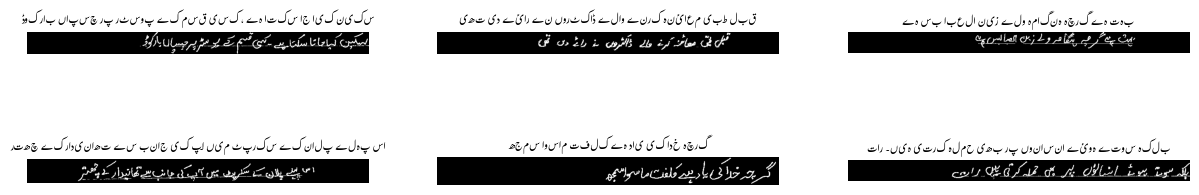

In [5]:
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
from matplotlib import font_manager

# Load a font that supports Urdu text
font_path = '/content/UrdType.ttf'  # Specify the correct path to your Urdu font
prop = font_manager.FontProperties(fname=font_path)

plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    # Get the correct image path from the 'file_name' column
    img_dir = train.loc[i, 'file_name']
    # Read the image using cv2.imread
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    # Check if the image was loaded successfully
    if image is not None:
        plt.imshow(image, cmap='gray')
        # Use the font properties for the title to render Urdu text
        plt.title(train.loc[i, 'text'][::-1], fontsize=12, fontproperties=prop)
        plt.axis('off')
    else:
        print(f"Failed to load image: {img_dir}")

plt.subplots_adjust(wspace=0.2, hspace=-0.8)
plt.show()  # Add plt.show() to display the plot


## Cleaning Data

Let's check for NaNs in our label.

In [6]:
print("Number of NaNs in train set      : ", train['text'].isnull().sum())
print("Number of NaNs in validation set : ", valid['text'].isnull().sum())

Number of NaNs in train set      :  0
Number of NaNs in validation set :  0


In [7]:
train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)

## Preprocessing and preparing the images for training

* The images are loaded as grayscale and reshaped to width 256 and height 64.  
* The width and height are cropped if they are greater than 256 and 64 respectively. If they are smaller, then the image is padded with white pixels. Finally the image is rotated clockwise to bring the image shape to (x, y).
* The image is then normalized to range [0, 1]

In [8]:

def preprocess(img):
    final_img = np.ones([64, 256]) * 255
    h, w = img.shape
    final_img[:min(h, 64), :min(w, 256)] = img[:min(h, 64), :min(w, 256)]
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

The model will be trained on 30000 images and validate on 3000 images

In [9]:
train_size = 7200
valid_size= 1800

In [10]:
train_x = []

for i in range(train_size):
    img_dir = train.loc[i, 'file_name']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    train_x.append(image)


In [ ]:
# train_x = []
# if len(train_x) == 0:
#     print("train_x is empty")
# else:
#     print("train_x is not empty")

train_x is empty


In [11]:
valid_x = []

for i in range(valid_size):
    img_dir = valid.loc[i, 'file_name']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)

In [12]:
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

## Preparing the labels for CTC Loss

Learn more about CTC loss and why its amazing for text recognition from [here](https://theailearner.com/2019/05/29/connectionist-temporal-classificationctc/).

The labels have to be converted to numbers which represent each character in the training set. The 'alphabets' consist of A-Z and three special characters (-  '  and space).

In [13]:
# alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
alphabets = " - بـ تـ ثـ جـ حـ خـ سـ شـ صـ ضـ طـ ظـ عـ غـ فـ قـ كـ لـ مـ نـ يـ آ ا ب پ ت ٹ ث ج چ ح خ د ڈ ذ ر ڑ ز ژ س ش ص ض ط ظ ع غ ف ق ک گ ل م ن ں و ہ ھ ء ی ے آ ؤ ئ ء ـبـ ـتـ ـثـ ـجـ ـحـ ـخـ ـسـ ـشـ ـصـ ـضـ ـطـ ـظـ ـعـ ـغـ ـفـ ـقـ ـكـ ـلـ ـمـ ـنـ ـيـ"
# alphabets = "- ا آ أ إ ب پ ت ٹ ث ج چ ح خ د ڈ ذ ر ڑ ز ژ س ش ص ض ط ظ ع غ ف ق ک گ ل م ن ں و ؤ ہ ھ ء ی ئ ے ۂ ۃ ؁ ؀ ۔ ، × ٫ ٬ ؍ ؎ ؏ ؐ ؑ ؒ ؓ ؔ ؕ ؖ ؗ ؘ ؙ ؚ ؛ ٪ ؟ ۰ ۱ ۲ ۳ ۴ ۵ ۶ ۷ ۸ ۹ ۾ ٠ ١ ٢ ٣ ٤ ٥ ٦ ٧ ٨ ٩ ـ ً ٌ ٍ َ ُ ِ ّ ْ ٓ ٔ ٕ ٖ ٗ ٘ ٙ ٚ ٛ ٜ ٝ ٞ ٟ ٰ ٖ ٘ ٗ ٓ "

# print(len(alphabets))
max_str_len = 64 # max length of input labels
num_of_characters = len(alphabets) + 1
num_of_timestamps = 128 # max length of predicted labels


def label_to_num(label):
    # Ensure stripping of special characters
    text = label.strip('\ufeff').strip()
    return np.array([alphabets.find(ch) if alphabets.find(ch) != -1 else 0 for ch in text])


def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret


In [14]:
name = 'کون سوچ سکتا تھا کہ ہندوستان اکثریت اورانگریزحکمرانوں کی مشترکہ'
print(name, '\n',label_to_num(name))
print(num_to_label(label_to_num(name)))

کون سوچ سکتا تھا کہ ہندوستان اکثریت اورانگریزحکمرانوں کی مشترکہ 
 [122 134  60   0  21 134  82   0  21 122   6  68   0   6 138  68   0 122
 136   0 136  60  88 134  21   6  68  60   0  68 122   9  94 142   6   0
  68 134  94  68  60 124  94 142  98  15 122  57  94  68  60 134 132   0
 122 142   0  57  24   6  94 122 136]
کون سوچ سکتا تھا کہ ہندوستان اکثریت اورانگریزحکمرانوں کی مشترکہ


* **train_y** contains the true labels converted to numbers and padded with -1. The length of each label is equal to max_str_len.
* **train_label_len** contains the length of each true label (without padding)
* **train_input_len** contains the length of each predicted label. The length of all the predicted labels is constant i.e number of timestamps - 2.  
* **train_output** is a dummy output for ctc loss.


In [15]:
# First, get max length of labels
max_str_len = 64  # Set fixed length

train_x = np.array(train_x).reshape(-1, 256, 64, 1)
train_y = np.zeros([train_x.shape[0], max_str_len])  # Use zeros instead of ones
train_label_len = np.zeros([train_x.shape[0], 1])  # Match first dimension
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_x.shape[0]):
    text = train.loc[i, 'text'].strip('\ufeff').strip()
    text = text[:max_str_len]  # Truncate to max length
    label_nums = label_to_num(text)
    train_y[i, :len(label_nums)] = label_nums  # Fill only up to label length
    train_label_len[i] = len(text)

In [16]:
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)
valid_y = np.zeros([valid_x.shape[0], max_str_len])
valid_label_len = np.zeros([valid_x.shape[0], 1])

# Get the actual number of rows in 'valid' DataFrame
num_rows = len(valid)

for i in range(num_rows):  # Iterate over the actual number of rows
    text = valid.loc[i, 'text'].strip('\ufeff').strip()
    text = text[:max_str_len]
    label_nums = label_to_num(text)
    valid_y[i, :len(label_nums)] = label_nums  # Fill only up to label length
    valid_label_len[i] = len(text)

In [21]:
def validate_labels(data):
    for i, text in enumerate(data['text']):
        nums = label_to_num(text)
        if any(n < 0 or n >= num_of_characters for n in nums):
            print(f"Invalid labels at index {i}:", text)
            print("Converted indices:", nums)

validate_labels(train)

In [22]:
print('True label : ',train.loc[38, 'text'] , '\ntrain_y : ',train_y[38],'\ntrain_label_len : ',train_label_len[38],
      '\ntrain_input_len : ', train_input_len[38])


True label :  اپنی دیوار کے ساتھ چپکارکھا تھا۔ اب صرف نجات کا ایک ہی راستہ تھا 
train_y :  [ 68.  72.  60. 142.   0.  88. 142. 134.  68.  94.   0. 122. 144.   0.
  21.  68.   6. 138.   0.  82.  72. 122.  68.  94. 122. 138.  68.   0.
   6. 138.  68.   0.   0.  68.   3.   0.  27.  94.  45.   0.  60.  12.
  68.   6.   0. 122.  68.   0.  68. 142. 122.   0. 136. 142.   0.  94.
  68.  21.   6. 136.   0.   6. 138.  68.] 
train_label_len :  [64.] 
train_input_len :  [126.]


## Building our model


In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Reshape, Dense, LSTM, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        return y_pred

# num_of_characters = 100  # Update based on your dataset

# Define inputs
input_data = Input(shape=(256, 64, 1), name='input')
labels = Input(name='labels', shape=(None,), dtype='float32')  # y_true input

# Define the network layers
inner = Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal')(input_data)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2))(inner)

inner = Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2))(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2))(inner)
inner = Dropout(0.3)(inner)

inner = Reshape(target_shape=((128, 512)))(inner)  # Update based on your feature dimensions
inner = Dense(64, activation='relu', kernel_initializer='he_normal')(inner)

inner = Dense(num_of_characters, kernel_initializer='he_normal')(inner)
y_pred = Activation('softmax')(inner)

# Add the CTC layer
ctc_output = CTCLayer(name='ctc_loss')(labels, y_pred)

# Define the model
model = Model(inputs=[input_data, labels], outputs=ctc_output)

# Compile
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt)


In [40]:
# history = model.fit(
#     x=[train_x, train_y],
#     validation_data=([valid_x, valid_y], None),  # Validation labels aren't used for loss calculation
#     epochs=20,
#     batch_size=32
# )
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor (validation loss in this case)
    patience=5,          # Number of epochs with no improvement before stopping
    restore_best_weights=True,  # Restore the weights of the best epoch
    verbose=1            # Enable verbosity for better logging
)

# Train the model
history = model.fit(
    [train_x, train_y],  # Training data (input images and labels)
    validation_data=([valid_x, valid_y], None),  # Validation data
    epochs=2,               # Maximum number of epochs
    batch_size=32,           # Batch size
    callbacks=[early_stopping]  # Add the early stopping callback
)
model.save('model.keras')

Epoch 1/2
225/225 ━━━━━━━━━━━━━━━━━━━━ 430s 2s/step - loss: 5334.0449 - val_loss: 5308.3384
Epoch 2/2
225/225 ━━━━━━━━━━━━━━━━━━━━ 441s 2s/step - loss: 5313.8159 - val_loss: 5295.1260
Restoring model weights from the end of the best epoch: 2.


In [ ]:
# Check the shapes of your data
print("Shape of train_x:", train_x.shape)
print("Shape of train_y:", train_y.shape)

Shape of train_x: (80, 256, 64, 1)
Shape of train_y: (80, 64)


## Check model performance on validation set

In [42]:

inference_model = Model(inputs=input_data, outputs=y_pred)

# Use the inference model for prediction
preds = inference_model.predict(valid_x)
import numpy as np
from tensorflow.keras import backend as K

# Decode predictions
decoded, log_probs = K.ctc_decode(
    preds,
    input_length=np.ones(preds.shape[0]) * preds.shape[1],
    greedy=True
)

# Convert the decoded output to a NumPy array
decoded = K.get_value(decoded[0])

# Convert numeric predictions to labels
prediction = []
for seq in decoded:
    prediction.append(num_to_label(seq))  # Convert indices to readable text

# Print sample predictions
for i, pred in enumerate(prediction[:10]):
    print(f"Prediction {i + 1}: {pred}")


57/57 ━━━━━━━━━━━━━━━━━━━━ 20s 348ms/step
Prediction 1: کی                                                              
Prediction 2: کی                                                              
Prediction 3: کی                                                              
Prediction 4: کی                                                              
Prediction 5: کی                                                              
Prediction 6: کی                                                              
Prediction 7: کی                                                              
Prediction 8: کی                                                              
Prediction 9: کی                                                              
Prediction 10: کی                                                              


In [43]:
y_true = valid.loc[0:valid_size, 'text']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)

    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1

    if pr == tr :
        correct += 1

print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))

Correct characters predicted : 20.29%


## Some predictions on test set

In [27]:
import os
import pandas as pd
import zipfile
from sklearn.model_selection import train_test_split

# Define paths to your zip files
image_zip_path = "test_images.zip"
label_zip_path = "test_labels.zip"
output_dir = "dataset_output"  # Directory to store extracted data

def extract_zip(zip_path, extract_to):
    """Extract the contents of a zip file to a specified directory."""
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for file in zip_ref.namelist():
            if "__MACOSX" in file or file.endswith('/'):  # Skip _MACOSX and directories
                continue

            # Extract file to the correct location
            file_name = os.path.basename(file)  # Get the actual file name
            dest_path = os.path.join(extract_to, file_name)  # Destination path for the file
            with zip_ref.open(file) as source, open(dest_path, 'wb') as target:
                target.write(source.read())

# Extract images and labels
image_dir = os.path.join(output_dir, "images")
label_dir = os.path.join(output_dir, "labels")
os.makedirs(image_dir, exist_ok=True)
os.makedirs(label_dir, exist_ok=True)

extract_zip(image_zip_path, image_dir)
extract_zip(label_zip_path, label_dir)

# Step 2: Match images and labels
data = []
for img_name in sorted(os.listdir(image_dir)):  # Sort to align files if naming is consistent
    # if img_name == "__MACOSX":  # Skip the _MACOSX folder
    #     continue

    img_path = os.path.join(image_dir, img_name)
    label_name = os.path.splitext(img_name)[0] + ".txt"  # Assuming same base name for labels
    label_path = os.path.join(label_dir, label_name)

    if os.path.exists(label_path):
        with open(label_path, 'r', encoding="utf-8") as label_file:
            label_text = label_file.read().strip()
        data.append({"file_name": img_path, "text": label_text})
    else:
        print(f"Label not found for image: {img_name}")

# Step 3: Create a DataFrame and save to CSV
df = pd.DataFrame(data)
csv_path = os.path.join(output_dir, "dataset.csv")
df.to_csv(csv_path, index=False)
print(f"Dataset CSV saved to {csv_path}")



Dataset CSV saved to dataset_output/dataset.csv


In [35]:
import pandas as pd
import cv2
test = pd.read_csv('/content/dataset_output/dataset.csv')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━

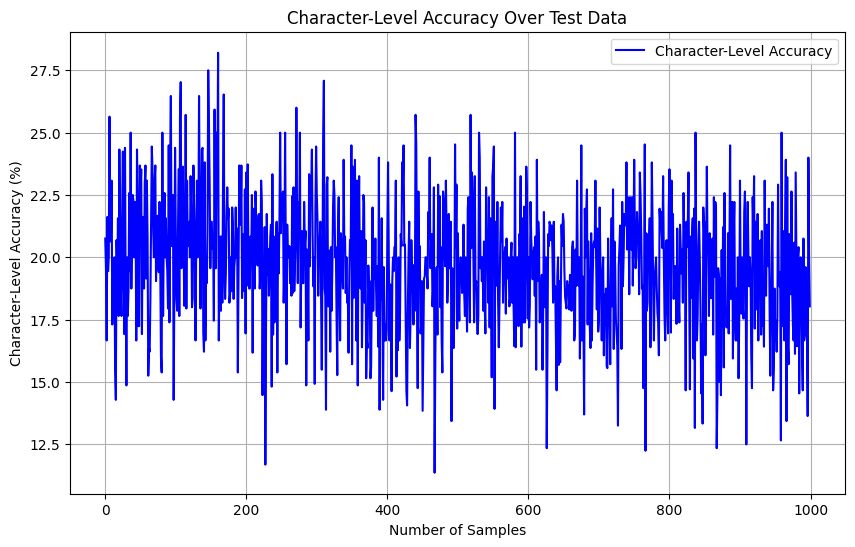

In [39]:
# Initialize lists to store character-level accuracies for each sample
char_accuracies = []

# Assuming test DataFrame is already loaded
y_true = test['text']  # Ground truth text from the test dataset
correct_char = 0
total_char = 0

valid_size = len(test)  # Use the full test dataset size

for i in range(valid_size):
    # Load and preprocess the image
    img_dir = test.loc[i, 'file_name']
    true_text = test.loc[i, 'text']  # Ground truth label

    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Error loading image: {img_dir}")
        continue

    image = preprocess(image)  # Ensure preprocess is properly defined
    image = image / 255.0  # Normalize the image
    image = np.expand_dims(image, axis=-1)  # Add channel dimension
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Create the second input (adjust shape and data type if needed)
    second_input = np.zeros((1, 10))  # Example shape, modify if necessary

    # Get the prediction using both inputs
    pred = model.predict([image, second_input])
    decoded = tf.keras.backend.eval(
        tf.keras.backend.ctc_decode(
            pred,
            input_length=np.ones(pred.shape[0]) * pred.shape[1],
            greedy=True
        )[0][0]
    )
    pr = num_to_label(decoded[0])  # Convert numerical prediction to text

    # Compare predicted and true labels for character-level accuracy
    total_chars_in_sample = len(true_text)
    correct_chars_in_sample = sum(1 for j in range(min(len(true_text), len(pr))) if true_text[j] == pr[j])

    # Update total counters
    correct_char += correct_chars_in_sample
    total_char += total_chars_in_sample

    # Calculate character-level accuracy for the current sample
    sample_accuracy = (correct_chars_in_sample / total_chars_in_sample) * 100
    char_accuracies.append(sample_accuracy)

# Calculate overall character-level accuracy
overall_char_accuracy = (correct_char / total_char) * 100

# Print overall accuracy
print('Overall Correct characters predicted : %.2f%%' % overall_char_accuracy)

# Plot character-level accuracy over the test dataset
plt.figure(figsize=(10, 6))
plt.plot(range(len(char_accuracies)), char_accuracies, label='Character-Level Accuracy', color='blue')

# Plot settings
plt.title('Character-Level Accuracy Over Test Data')
plt.xlabel('Number of Samples')
plt.ylabel('Character-Level Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()
